## Milestone Project 1: 🍔👁 Food Vision Big™

In the previous notebook (transfer learning part 3: scaling up) we built Food Vision mini: a transfer learning model which beat the original results of the Food101 paper with only 10% of the data.

But you might be wondering, what would happen if we used all the data?

Well, that's what we're going to find out in this notebook!

We're going to be building Food Vision Big™, using all of the data from the Food101 dataset.

Yep. All 75,750 training images and 25,250 testing images.

And guess what...

This time **we've got the goal of beating [DeepFood](https://www.researchgate.net/publication/304163308_DeepFood_Deep_Learning-Based_Food_Image_Recognition_for_Computer-Aided_Dietary_Assessment)**, a 2016 paper which used a Convolutional Neural Network trained for 2-3 days to achieve 77.4% top-1 accuracy.

🔑 **Note: Top-1 accuracy** means "accuracy for the top softmax activation value output by the model" (because softmax ouputs a value for every class, but top-1 means only the highest one is evaluated). **Top-5 accuracy** means "accuracy for the top 5 softmax activation values output by the model", in other words, did the true label appear in the top 5 activation values? Top-5 accuracy scores are usually noticeably higher than top-1.
![foodVisionBig.png](Images/foodVisionBig.png)

Table comparing difference between Food Vision Big (this notebook) versus Food Vision mini (previous notebook).

Alongside attempting to beat the DeepFood paper, we're going to learn about two methods to significantly improve the speed of our model training:

* Prefetching
* Mixed precision training

But more on these later.

### What we're going to cover

* Using TensorFlow Datasets to download and explore data
* Creating preprocessing function for our data
* Batching & preparing datasets for modelling (**making our datasets run fast**)
* Creating modelling callbacks
* Setting up **mixed precision training**
* Building a feature extraction model (see [transfer learning part 1: feature extraction](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb))
* Fine-tuning the feature extraction model (see [transfer learning part 2: fine-tuning](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb))
* Viewing training results on TensorBoard

## Check GPU

For this notebook, we're going to be doing something different.

We're going to be using mixed precision training.

Mixed precision training was introduced in `TensorFlow 2.4.0` (a very new feature at the time of writing).

### What does mixed precision training do?

**Mixed precision training** uses a combination of single precision (**float32**) and half-preicison (**float16**) data types to speed up model training (up 3x on modern GPUs).

We'll talk about this more later on but in the meantime you can read the [TensorFlow documentation on mixed precision](https://www.tensorflow.org/guide/mixed_precision) for more details.

For now, before we can move forward if we want to use mixed precision training, we need to make sure the GPU powering our Google Colab instance (if you're using Google Colab) is compataible.

For mixed precision training to work, you need access to a GPU with a compute compability score of 7.0+.

Google Colab offers P100, K80 and T4 GPUs, however, the P100 and K80 aren't compatible with mixed precision training.

Therefore before we proceed we need to make sure we have access to a Tesla T4 GPU in our Google Colab instance.

If you're not using Google Colab, you can find a list of various [Nvidia GPU compute capabilities](https://developer.nvidia.com/cuda-gpus#compute) on Nvidia's developer website.

🔑 Note: If you run the cell below and see a P100 or K80, try going to to Runtime -> Factory Reset Runtime (note: this will remove any saved variables and data from your Colab instance) and then retry to get a T4.

In [1]:
# Check TensorFlow version (should be 2.4.0+)
import tensorflow as tf
print(tf.__version__)

Init Plugin
2.5.0
Init Graph Optimizer
Init Kernel


## Get helper functions

We've created a series of helper functions throughout the previous notebooks in the course. Instead of rewriting them (tedious), we'll import the `helper_functions.py` file from the GitHub repo.

In [2]:
# Get helper functions file
import os 

if not os.path.exists("helper_functions.py"):
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
    print("[INFO] 'helper_functions.py' already exists, skipping download.")

[INFO] 'helper_functions.py' already exists, skipping download.


In [3]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets to Download Data

In previous notebooks, we've downloaded our food images (from the [Food101 dataset](https://www.kaggle.com/dansbecker/food-101/home)) from Google Storage.

And this is a typical workflow you'd use if you're working on your own datasets.

However, there's another way to get datasets ready to use with TensorFlow.

For many of the most popular datasets in the machine learning world (often referred to and used as benchmarks), you can access them through [TensorFlow Datasets](https://www.tensorflow.org/datasets/overview) (TFDS).

What is TensorFlow Datasets?

A place for prepared and ready-to-use machine learning datasets.

Why use TensorFlow Datasets?

* Load data already in Tensors
* Practice on well established datasets
* Experiment with differet data loading techniques (like we're going to use in this notebook)
* Experiment with new TensorFlow features quickly (such as mixed precision training)

Why not use TensorFlow Datasets?

The datasets are static (they don't change, like your real-world datasets would)
Might not be suited for your particular problem (but great for experimenting)
To begin using TensorFlow Datasets we can import it under the alias tfds.

In [6]:
#Get TensorFlow Datasets
!pip install tensorflow_datasets
import tensorflow_datasets as tfds

  Using cached tensorflow_datasets-4.7.0-py3-none-any.whl (4.7 MB)
  Using cached etils-0.9.0-py3-none-any.whl (140 kB)
  Using cached dill-0.3.6-py3-none-any.whl (110 kB)
  Using cached promise-2.3.tar.gz (19 kB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 kB 1.5 MB/s eta 0:00:00
  Using cached googleapis_common_protos-1.57.0-py2.py3-none-any.whl (217 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 5.5 MB/s eta 0:00:00
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21486 sha256=8ee1b261b60bdbd731e163fbc32d2dc0cfc6225567b93ba0e02befdcaacaea9d
  Stored in directory: /Users/snigdhakakkar/Library/Caches/pip/wheels/e1/e8/83/ddea66100678d139b14bc87692ece57c6a2a937956d2532608
Successfully built promise
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.1
    Uninstalling protobuf-3.20.1:
      Successfully uninstalled protobuf-3.20.1


To find all of the available datasets in TensorFlow Datasets, you can use the `list_builders()` method.

After doing so, we can check to see if the one we're after ("food101") is present.

In [7]:
# List available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is the dataset we're after available?

2022-12-14 23:41:27.194704: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


True


Beautiful! It looks like the dataset we're after is available (note there are plenty more available but we're on Food101).

To get access to the Food101 dataset from the TFDS, we can use the `tfds.load()` method.

In particular, we'll have to pass it a few parameters to let it know what we're after:

* `name` (str) : the target dataset (e.g. "`food101`")
* `split` (list, optional) : what splits of the dataset we're after (e.g. ["train", "validation"])
* the `split` parameter is quite tricky. See the documentation for more.
* `shuffle_files` (bool) : whether or not to shuffle the files on download, defaults to False
* `as_supervised` (bool) : True to download data samples in tuple format ((data, label)) or False for dictionary format
* `with_info` (bool) : True to download dataset metadata (labels, number of samples, etc)

🔑 **Note**: Calling the `tfds.load()` method will start to download a target dataset to disk if the `download=True` parameter is set (default). This dataset could be 100GB+, so make sure you have space.

In [8]:
# Load in the data (takes about 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101", # target dataset to get from TFDS
                                             split=["train", "validation"], # what splits of data should we get? note: not all datasets have train, valid, test
                                             shuffle_files=True, # shuffle files on download?
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True) # include dataset metadata? if so, tfds.load() returns tuple (data, ds_info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /Users/snigdhakakkar/tensorflow_datasets/food101/2.0.0.incompleteBLSCP3/food101-train.tfrecord*...: …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /Users/snigdhakakkar/tensorflow_datasets/food101/2.0.0.incompleteBLSCP3/food101-validation.tfrecord*…

Dataset food101 downloaded and prepared to /Users/snigdhakakkar/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.
Metal device set to: Apple M1


2022-12-14 23:59:22.070708: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-14 23:59:22.071239: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Wonderful! After a few minutes of downloading, we've now got access to entire Food101 dataset (in tensor format) ready for modelling.

Now let's get a little information from our dataset, starting with the class names.

Getting class names from a TensorFlow Datasets dataset requires downloading the "`dataset_info`" variable (by using the `as_supervised=True` parameter in the `tfds.load()` method, note: this will only work for supervised datasets in TFDS).

We can access the class names of a particular dataset using the `dataset_info.features` attribute and accessing `names` attribute of the the "label" key.

In [9]:
# Features of Food101 TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [10]:
# Get class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

## Exploring the Food101 data from TensorFlow Datasets

Now we've downloaded the Food101 dataset from TensorFlow Datasets, how about we do what any good data explorer should?

In other words, "visualize, visualize, visualize".

Let's find out a few details about our dataset:

* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels of our input data look like (e.g. one-hot encoded versus label-encoded)
* Do the labels match up with the class names?
* To do, let's take one sample off the training data (using the `[.take()` method](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take)) and explore it.

In [11]:
# Take one sample off the training data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

Because we used the `as_supervised=True` parameter in our `tfds.load()` method above, data samples come in the tuple format structure (data, label) or in our case (`image_tensor`, `label`).

In [12]:
# What does one sample of our training data look like?
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

Let's loop through our single training sample and get some info from the `image_tensor` and `label`.

In [13]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 384, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 74
  Class name (str form): peking_duck
        


2022-12-15 00:02:58.799211: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-15 00:02:58.799939: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Because we set the shuffle_files=True parameter in our `tfds.load()` method above, running the cell above a few times will give a different result each time.

Checking these you might notice some of the images have different shapes, for example (512, 342, 3) and (512, 512, 3) (height, width, color_channels).

Let's see what one of the image tensors from TFDS's Food101 dataset looks like.

In [14]:
# What does an image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 384, 3), dtype=uint8, numpy=
array([[[152, 129,  77],
        [160, 137,  85],
        [160, 137,  85],
        ...,
        [ 26,  21,  18],
        [ 24,  19,  16],
        [ 21,  16,  13]],

       [[156, 133,  81],
        [158, 135,  83],
        [155, 132,  80],
        ...,
        [ 25,  20,  17],
        [ 23,  18,  15],
        [ 22,  17,  14]],

       [[164, 141,  87],
        [159, 136,  82],
        [147, 124,  70],
        ...,
        [ 23,  18,  15],
        [ 21,  17,  14],
        [ 20,  16,  13]],

       ...,

       [[  1,  49, 121],
        [  0,  47, 119],
        [  0,  48, 120],
        ...,
        [ 26,  14,  16],
        [ 26,  14,  16],
        [ 32,  20,  22]],

       [[  1,  49, 121],
        [  0,  47, 119],
        [  0,  48, 120],
        ...,
        [ 24,  14,  15],
        [ 30,  18,  18],
        [ 30,  18,  18]],

       [[  2,  50, 122],
        [  0,  48, 120],
        [  0,  48, 120],
        ...,
        [ 22,  12,  1

In [15]:
# What are the min and max values?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

Alright looks like our image tensors have values of between 0 & 255 (standard red, green, blue colour values) and the values are of data type `unit8`.

We might have to preprocess these before passing them to a neural network. But we'll handle this later.

In the meantime, let's see if we can plot an image sample.

## Plot an image from TensorFlow Datasets

We've seen our image tensors in tensor format, now let's really adhere to our motto.

"Visualize, visualize, visualize!"

Let's plot one of the image samples using `matplotlib.pyplot.imshow()` and set the title to target class name.

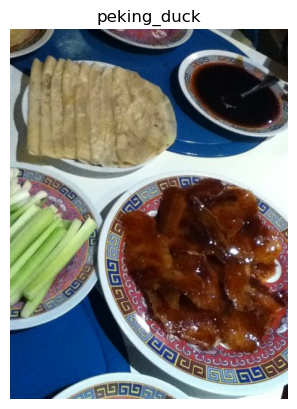

In [17]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to image by indexing on class_names list
plt.axis(False);

Delicious!

Okay, looks like the Food101 data we've got from TFDS is similar to the datasets we've been using in previous notebooks.

Now let's preprocess it and get it ready for use with a neural network.

## Create preprocessing functions for our data

In previous notebooks, when our images were in folder format we used the method `tf.keras.utils.image_dataset_from_directory()` to load them in.

Doing this meant our data was loaded into a format ready to be used with our models.

However, since we've downloaded the data from TensorFlow Datasets, there are a couple of preprocessing steps we have to take before it's ready to model.

More specifically, our data is currently:

In `uint8` data type
Comprised of all `differnet sized tensors` (different sized images)
Not scaled (the pixel values are between 0 & 255)
Whereas, models like data to be:

In `float32` data type
Have all of the same size tensors (batches require all tensors have the same shape, e.g. (224, 224, 3))
Scaled (values between 0 & 1), also called normalized
To take care of these, we'll create a `preprocess_img()` function which:

1. Resizes an input image tensor to a specified size using `tf.image.resize()`
2. Converts an input image tensor's current datatype to `tf.float32` using `tf.cast()`

### 🔑 Note: Pretrained EfficientNetBX models in tf.keras.applications.efficientnet (what we're going to be using) have rescaling built-in. But for many other model architectures you'll want to rescale your data (e.g. get its values between 0 & 1). This could be incorporated inside your "preprocess_img()" function (like the one below) or within your model as a `tf.keras.layers.Rescaling layer`.

In [18]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes image to
    [img_shape, img_shape, color_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

Our `preprocess_img()` function above takes image and label as input (even though it does nothing to the label) because our dataset is currently in the `tuple structure (image, label)`.

Let's try our function out on a target image.

In [19]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[152 129  77]
  [160 137  85]
  [160 137  85]
  ...
  [ 26  21  18]
  [ 24  19  16]
  [ 21  16  13]]

 [[156 133  81]
  [158 135  83]
  [155 132  80]
  ...
  [ 25  20  17]
  [ 23  18  15]
  [ 22  17  14]]]...,
Shape: (512, 384, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[156.05103  133.05103   81.05102 ]
  [156.13776  133.13776   81.13776 ]
  [146.31122  123.311226  71.311226]
  ...
  [ 22.454105  17.454105  13.668401]
  [ 25.306135  20.306135  17.306135]
  [ 22.25511   17.25511   14.25511 ]]

 [[159.82652  136.82652   82.82653 ]
  [149.79591  126.79591   72.79591 ]
  [132.69388  109.69388   57.26531 ]
  ...
  [ 24.183672  19.183672  15.397966]
  [ 22.21425   17.21425   14.214251]
  [ 18.83164   14.83164   11.83164 ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


Excellent! Looks like our `preprocess_img()` function is working as expected.

The input image gets converted from `uint8` to `float32` and gets reshaped from its current shape to `(224, 224, 3)`.

How does it look?

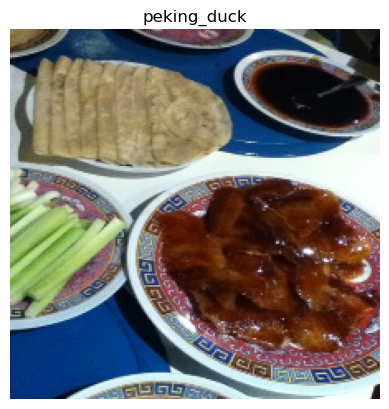

In [20]:
# We can still plot our preprocessed image as long as we 
# divide by 255 (for matplotlib capatibility)
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

All this food visualization is making me hungry. How about we start preparing to model it?

## Batch & prepare datasets

Before we can model our data, we have to turn it into batches.

### Why?

Because computing on batches is memory efficient.

We turn our data from 101,000 image tensors and labels (train and test combined) into batches of 32 image and label pairs, thus enabling it to fit into the memory of our GPU.

To do this in effective way, we're going to be leveraging a number of methods from the `[tf.data`API](https://www.tensorflow.org/api_docs/python/tf/data).

### 📖 Resource: For loading data in the most performant way possible, see the TensorFlow docuemntation on [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance).

Specifically, we're going to be using:

* `map()` - maps a predefined function to a target dataset (e.g. preprocess_img() to our image tensors)
* `shuffle()` - randomly shuffles the elements of a target dataset up buffer_size (ideally, the buffer_size is equal to the size of the dataset, however, this may have implications on memory)
* `batch()` - turns elements of a target dataset into batches (size defined by parameter batch_size)
* `prefetch()` - prepares subsequent batches of data whilst other batches of data are being computed on (improves data loading speed but costs memory)
* `Extra`: cache() - caches (saves them for later) elements in a target dataset, saving loading time (will only work if your dataset is small enough to fit in memory, standard Colab instances only have 12GB of memory)
Things to note:

* Can't batch tensors of different shapes (e.g. different image sizes, need to reshape images first, hence our `preprocess_img()` function)
* `shuffle()` keeps a buffer of the number you pass it images shuffled, ideally this number would be all of the samples in your training set, however, if your training set is large, this buffer might not fit in memory (a fairly large number like 1000 or 10000 is usually suffice for shuffling)
* For methods with the `num_parallel_calls` parameter available (such as `map()`), setting it `tonum_parallel_calls=tf.data.AUTOTUNE` will parallelize preprocessing and significantly improve speed
* Can't use `cache()` unless your dataset can fit in memory

Woah, the above is alot. But once we've coded below, it'll start to make sense.

We're going to through things in the following order:

Original dataset (e.g. train_data) -> map() -> shuffle() -> batch() -> prefetch() -> PrefetchDataset
This is like saying,

"Hey, map this preprocessing function across our training dataset, then shuffle a number of elements before batching them together and make sure you prepare new batches (prefetch) whilst the model is looking through the current batch".

![prefetching](Images/prefetching.png)

What happens when you use prefetching (faster) versus what happens when you don't use prefetching (slower). Source:* Page 422 of [Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow Book by Aurélien Géron](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/).*

In [21]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [22]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

Excellent! Looks like our data is now in tutples of `(image, label)` with datatypes of `(tf.float32, tf.int64)`, just what our model is after.

🔑 **Note: You can get away without calling the prefetch() method on the end of your datasets, however, you'd probably see significantly slower data loading speeds when building a model. So most of your dataset input pipelines should end with a call to prefecth().

Onward.

Excellent! Looks like our data is now in tutples of (`image, label`) with datatypes of (`tf.float32, tf.int64`), just what our model is after.

🔑 **Note**: You can get away without calling the `prefetch()` method on the end of your datasets, however, you'd probably see significantly slower data loading speeds when building a model. So most of your dataset input pipelines should end with a call to prefecth().

Onward.

## Create modelling callbacks

Since we're going to be training on a large amount of data and training could take a long time, it's a good idea to set up some modelling callbacks so we be sure of things like our model's training logs being tracked and our model being checkpointed (saved) after various training milestones.

To do each of these we'll use the following callbacks:

* **`tf.keras.callbacks.TensorBoard()`** - allows us to keep track of our model's training history so we can inspect it later (note: we've created this callback before have imported it from `helper_functions.py` as `create_tensorboard_callback()`)
* **`tf.keras.callbacks.ModelCheckpoint()`** - saves our model's progress at various intervals so we can load it and resuse it later without having to retrain it
Checkpointing is also helpful so we can start fine-tuning our model at a particular epoch and revert back to a previous state if fine-tuning offers no benefits

In [23]:
# Create TensorBoard callback (already have "create_tensorboard_callback()" from a previous notebook)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved 